# Imports and library functions

In [28]:
%load_ext autoreload
%autoreload 2
%pip install ydata_profiling

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from dataclasses import dataclass
from functools import reduce

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import plot_tree
from ydata_profiling import ProfileReport

## Compose
a function that enables functional composition
compose :: function, function, ... -> function

compose(f, g, h, i)(x) is equivalent to i(h(g(f(x))))

In [30]:
def compose(*funcs):
    return reduce(lambda f, g: lambda x: g(f(x)), funcs, lambda x: x)

## Import The Data

In [31]:

data: DataFrame = pd.read_csv(
    "https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv"
)

# Data Exploration part 1

### Get the first few rows

In [32]:
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

### Get the last few rows

In [33]:
data.tail()

PassengerId  Survived  Pclass                                      Name  \
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
886    male  27.0      0      0      211536  13.00   NaN        S  
887  female  19.0      0      0      112053  30.00   B42        S  
888  female   NaN      1      2  W./C. 6607  23.45   NaN        S  
889    male  26.0      0      0      111369  30.00  C148        C  
890    male  32.0      0      0      370376   7.75   NaN        Q

### Get summary, data types, that sort of thing

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Get descriptive statistics

In [35]:
data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

### Get number of nulls

In [36]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### ydataprofiler

In [37]:
# ProfileReport(data, title="Titanic Profiling Report")

# Data Preprocessing

Here we are just getting rid of null values and dropping irrelevant data that we don't need

## Required libraries

### Data cleaning

In [38]:
from functools import partial
from typing import Callable, List

from pandas import DataFrame


def fillColumnNaWithMedian(data: DataFrame, columnName: str) -> DataFrame:
    columnMedian = data[columnName].median()
    return data.fillna(value={columnName: columnMedian})


def fillColumnNaWithMode(data: DataFrame, columnName: str) -> DataFrame:
    columnMode = data[columnName].mode()
    return data.fillna(value={columnName: columnMode})


def dataDropper(data: DataFrame, columns: List[str]):
    return data.drop(columns, axis=1)


cleanAge: Callable[[DataFrame], DataFrame] = partial(
    fillColumnNaWithMedian, columnName="Age"
)

cleanEmbarked: Callable[[DataFrame], DataFrame] = partial(
    fillColumnNaWithMode, columnName="Embarked"
)

cleanFare: Callable[[DataFrame], DataFrame] = partial(
    fillColumnNaWithMedian, columnName="Fare"
)

dropIrrelevant: Callable[[DataFrame], DataFrame] = partial(
    dataDropper, columns=["Name", "Ticket", "Cabin"]
)

### Numeric Conversion

In [39]:

from dataclasses import dataclass
from functools import partial
from typing import Callable

from pandas import DataFrame


@dataclass
class NumericConversionData:
    columnName: str
    conversionMap: dict[str, int]


def convertColToNumeric(
    data: DataFrame, columnData: NumericConversionData
) -> DataFrame:
    convertedData = data.copy()
    convertedData[columnData.columnName] = data[columnData.columnName].map(
        columnData.conversionMap  # type: ignore
    )
    return convertedData


SexConversion = NumericConversionData("Sex", {"male": 0, "female": 1})
sexConverter: Callable[[DataFrame], DataFrame] = partial(
    convertColToNumeric, columnData=SexConversion
)

EmbarkedConversion = NumericConversionData("Embarked", {"C": 0, "Q": 1, "S": 2})
embarkedConverter: Callable[[DataFrame], DataFrame] = partial(
    convertColToNumeric, columnData=EmbarkedConversion
)

In [40]:
cleanData = compose(cleanAge, cleanFare, cleanEmbarked, dropIrrelevant)
convertDataToNumeric = compose(sexConverter, embarkedConverter)

processedData = compose(cleanData, convertDataToNumeric)(data)
processedDataRows = len(processedData)

# Data Exploration Part II and Data Visualization

In [41]:
ProfileReport(processedData, title="Titanic")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 48.50it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

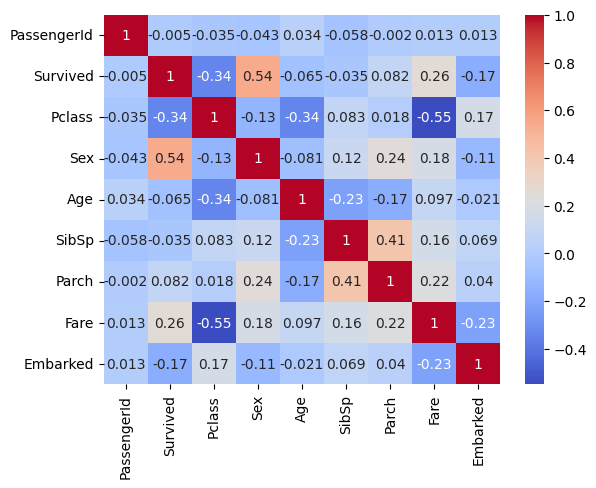

In [42]:
processedCorrMatrix = processedData.corr().round(3)
sns.heatmap(processedCorrMatrix, annot=True, cmap="coolwarm")
plt.show()

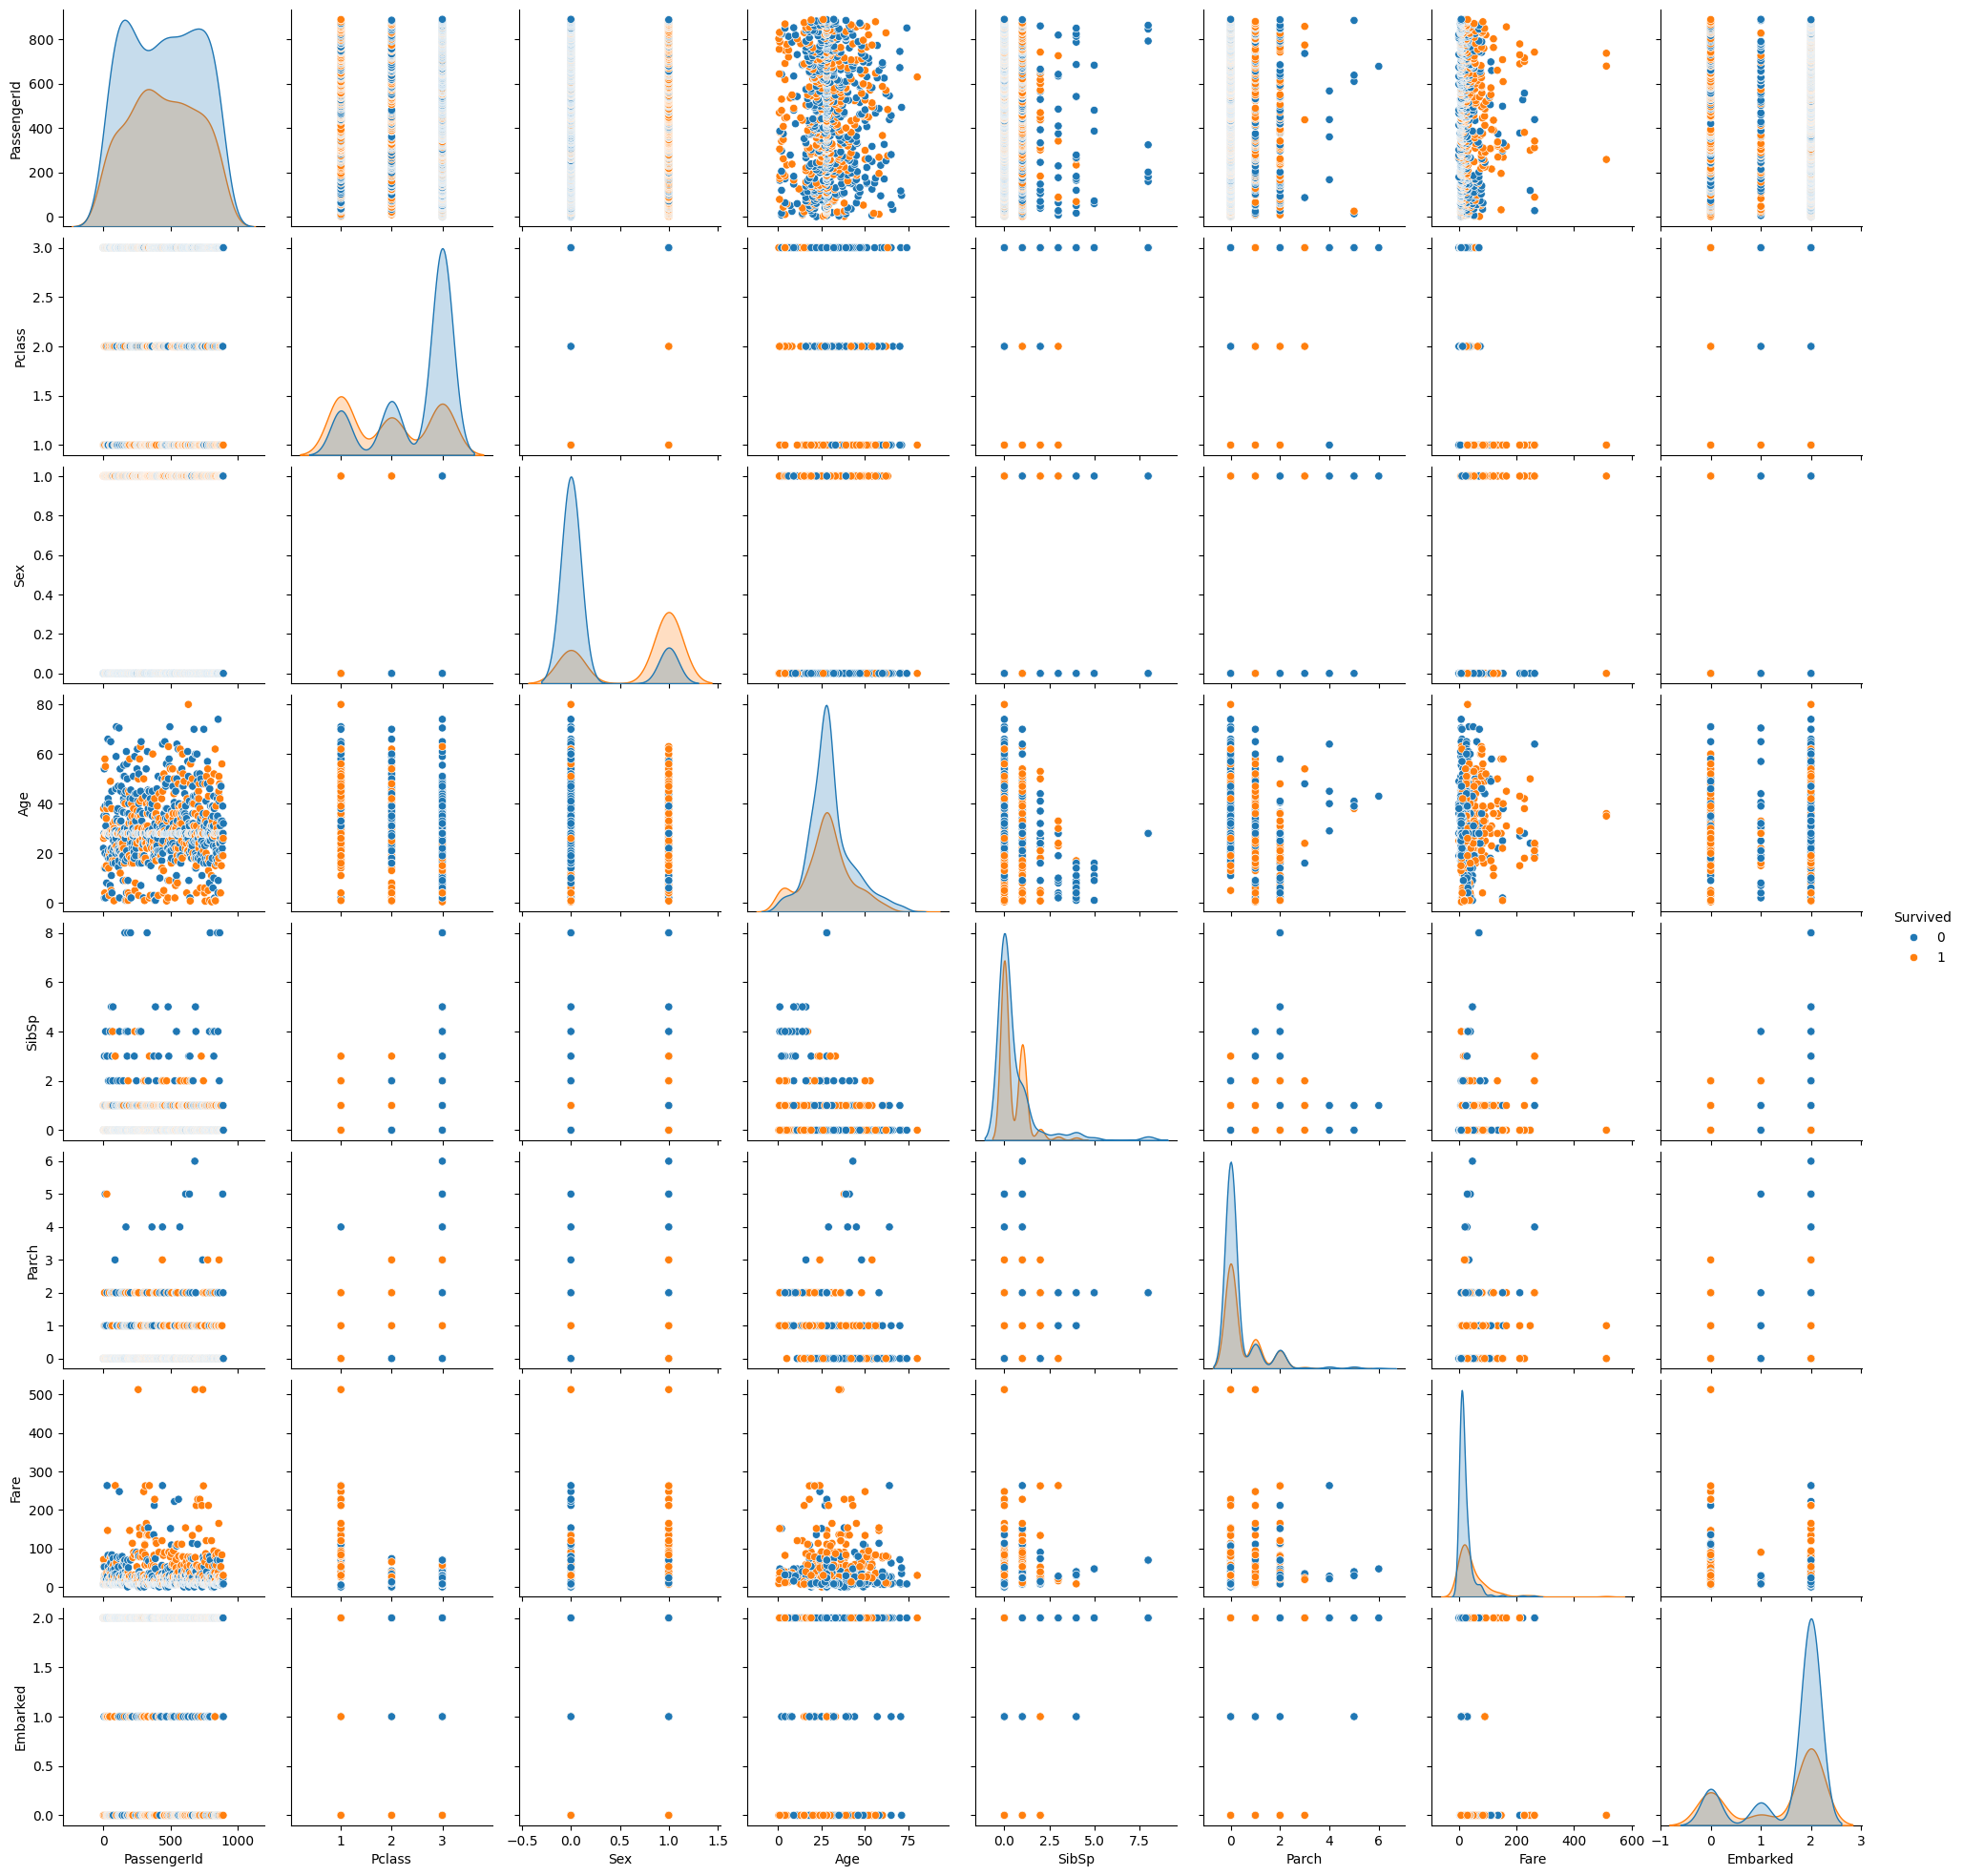

In [43]:
sns.pairplot(processedData, hue="Survived")
plt.show()

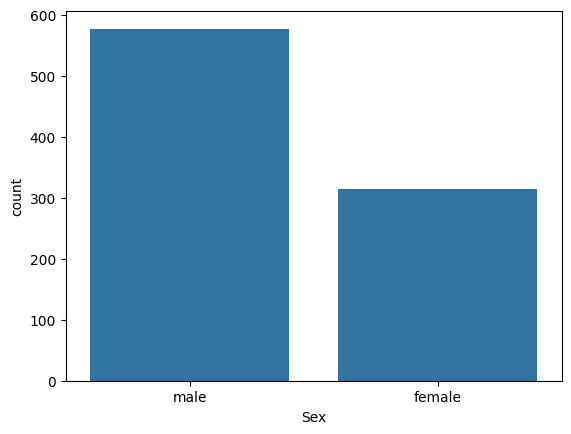

In [44]:
processDataCategoricalSex = compose(cleanData, embarkedConverter)(data)
sns.countplot(x="Sex", data=processDataCategoricalSex)
plt.show()

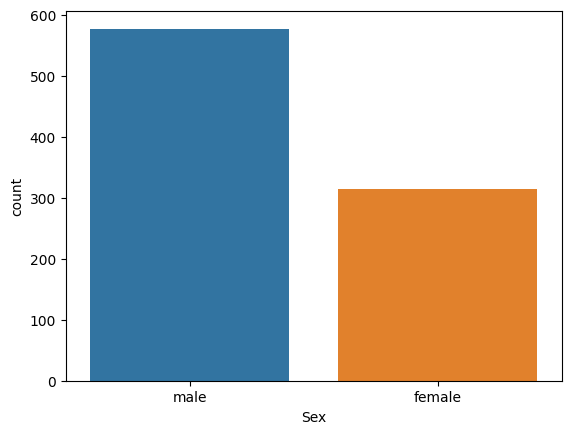

In [46]:
sns.countplot(x="Sex", hue="Sex", data=processDataCategoricalSex)
plt.show()

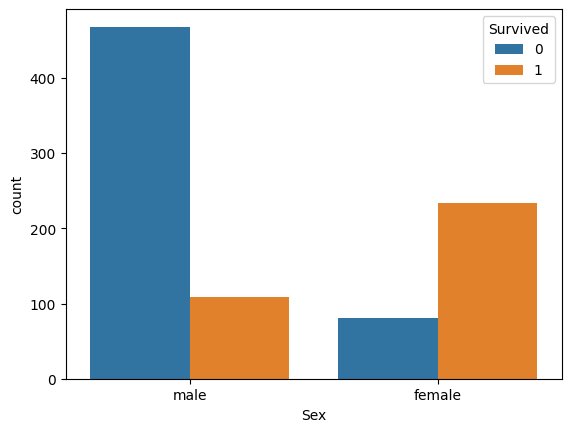

In [48]:
sns.countplot(x="Sex", hue="Survived", data=processDataCategoricalSex)
plt.show()